<a href="https://colab.research.google.com/github/vinay10949/AnalyticsAndML/blob/master/FeatureSelection/EmbeddedMethods/3_12_Feature_shuffling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Feature selection by random shuffling

A popular method of feature selection consists in random shuffling the values of a specific variable and determining how that permutation affects the performance metric of the machine learning algorithm. In other words, the idea is to permute the values of each feature, one at the time, and measure how much the permutation decreases the accuracy, or the roc_auc, or the mse of the machine learning model. If the variables are important, this is, highly predictive, a random permutation of their values will decrease dramatically any of these metrics. Contrarily, non-important / non-predictive variables, should have little to no effect on the model performance metric we are assessing.

I will demonstrate how to select features based on random shuffling using on a regression and classification problem. For classification I will use the Paribas claims dataset from Kaggle. For regression, the House Price dataset from Kaggle.

**Note** For the demonstration, I will continue to use Random Forests, but this method is useful for any machine learning algorithm. In fact, the importance of the features are determined specifically for the algorithm used. Therefore, different algorithms may return different subsets of important features.


In [2]:
!pip install --user kaggle
!mkdir .kaggle
import json
token = {"username":"vinay10949","key":"59c4901452f76ce62979e5b0997e240b"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

mkdir: cannot create directory ‘.kaggle’: File exists


In [5]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c bnp-paribas-cardif-claims-management
!unzip train.csv.zip

 97% 48.0M/49.4M [00:00<00:00, 45.3MB/s]
100% 49.4M/49.4M [00:00<00:00, 84.1MB/s]
  0% 0.00/162k [00:00<?, ?B/s]
100% 162k/162k [00:00<00:00, 165MB/s]
 75% 37.0M/49.4M [00:00<00:00, 32.8MB/s]
100% 49.4M/49.4M [00:01<00:00, 50.9MB/s]
Archive:  train.csv.zip
  inflating: train.csv               


In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error

In [6]:
# load dataset
data = pd.read_csv('train.csv', nrows=50000)
data.shape

(50000, 133)

In [0]:
data.head()

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN


In [7]:
# In practice, feature selection should be done after data pre-processing,
# so ideally, all the categorical variables are encoded into numbers,
# and then you can assess how deterministic they are of the target

# here for simplicity I will use only numerical variables
# select numerical columns:

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

(50000, 114)

### Important

In all feature selection procedures, it is good practice to select the features by examining only the training set. And this is to avoid overfit.

In [8]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target', 'ID'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 112), (15000, 112))

In [9]:
# The first step to determine feature importance by feature shuffling
# is to build the machine learning model for which we want to 
# select features

# In this case, I will build Random Forests, but remember that 
# you can use this procedure for any other machine learning algorithm

# I build few and shallow trees to avoid overfitting
rf = RandomForestClassifier(
    n_estimators=50, max_depth=2, random_state=2909, n_jobs=4)

rf.fit(X_train.fillna(0), y_train)

# print roc-auc in train and testing sets
print('train auc score: ',
      roc_auc_score(y_train, (rf.predict_proba(X_train.fillna(0)))[:, 1]))
print('test auc score: ',
      roc_auc_score(y_test, (rf.predict_proba(X_test.fillna(0)))[:, 1]))

train auc score:  0.6861741003488592
test auc score:  0.6761687228790215


In [0]:
# in this cell, I will shuffle one by one, each feature of the dataset
# and then use the dataset with the shuffled variable to make predictions
# using the random forests I trained in the previous cell

# overall train roc-auc: using all the features
train_auc = roc_auc_score(y_train, (rf.predict_proba(X_train.fillna(0)))[:, 1])

# dictionary to capture the features and the drop in auc that they
# cause when shuffled
feature_dict = {}

# selection  logic
for feature in X_train.columns:
    X_train_c = X_train.copy()
    
    # shuffle individual feature
    X_train_c[feature] = X_train_c[feature].sample(frac=1).reset_index(
        drop=True)
    
    # make prediction with shuffled feature and calculate roc-auc
    shuff_auc = roc_auc_score(y_train,
                              (rf.predict_proba(X_train_c.fillna(0)))[:, 1])
    
    # save the drop in roc-auc
    feature_dict[feature] = (train_auc - shuff_auc)

In [12]:
# let's have a look at the generated dictionary
feature_dict

{'v1': 0.0,
 'v10': 0.0037030625952859664,
 'v100': 0.0,
 'v101': 0.0001284334742758242,
 'v102': 0.0,
 'v103': 0.0,
 'v104': 0.0,
 'v105': 0.0,
 'v106': 0.0,
 'v108': 0.0,
 'v109': 0.0,
 'v11': 6.750338969474523e-05,
 'v111': -0.00020414398342993856,
 'v114': 0.0025901284059903773,
 'v115': 0.0,
 'v116': 0.0,
 'v117': 9.391522954715903e-05,
 'v118': 0.0,
 'v119': -0.0009167242769002604,
 'v12': -7.868494650375979e-05,
 'v120': 0.0,
 'v121': -7.132606764315153e-05,
 'v122': -0.00017706742733003544,
 'v123': 1.0091601211237311e-05,
 'v124': 0.0,
 'v126': 0.0,
 'v127': 0.0,
 'v128': 0.0,
 'v129': 0.010323625229380795,
 'v13': 0.0,
 'v130': 0.0,
 'v131': 0.0,
 'v14': 0.0019452148836492933,
 'v15': -0.00041078121231319376,
 'v16': 0.0,
 'v17': 0.0,
 'v18': 8.099466760591589e-05,
 'v19': -0.0004474368443022625,
 'v2': 0.0,
 'v20': 0.0,
 'v21': 0.0019821771355909013,
 'v23': 0.0,
 'v25': 0.0,
 'v26': 0.0,
 'v27': 0.00012120664342396559,
 'v28': 0.0,
 'v29': 0.0,
 'v32': -0.000697743916351245

In [14]:
# Now I will transform the dictionary into a pandas dataframe
# for easy manipulation

feature_importance = pd.Series(feature_dict).reset_index()
feature_importance.columns = ['feature', 'auc_drop']
feature_importance.head()

,feature,auc_drop
0,v1,0.000000
1,v2,0.000000
2,v4,0.000024
3,v5,0.000000
4,v6,0.000000


In [0]:
# Now I will sort the dataframe according to the drop in performance
# caused by feature shuffling

feature_importance.sort_values(by=['auc_drop'], ascending=False, inplace=True)

In [19]:
# visualise the top 10 features that caused the major drop
# in roc-auc (aka model performance)

feature_importance.head(10)

,feature,auc_drop
43,v50,0.070304
109,v129,0.010324
53,v62,0.006610
8,v10,0.003703
95,v114,0.002590
19,v21,0.001982
12,v14,0.001945
34,v40,0.001777
61,v72,0.001329
32,v38,0.001048


In [20]:
# visualise the features that caused virtually 
# no drop in performance

feature_importance.tail(10)

,feature,auc_drop
75,v89,-0.000276
68,v82,-0.000316
13,v15,-0.000411
58,v68,-0.000413
17,v19,-0.000447
26,v32,-0.000698
100,v119,-0.000917
30,v36,-0.000925
41,v48,-0.000946
62,v73,-0.000952


In [21]:
# original number of features (rows in this case)
feature_importance.shape[0]

112

In [22]:
# number of features that cause a drop in performance
# when shuffled

feature_importance[feature_importance.auc_drop>0].shape[0]

27

Only 26 out of the 110 features caused a drop in the performance of the random forests when their values were permuted. This means that we could select those features and discard the rest, and should keep the original random forest performance.  

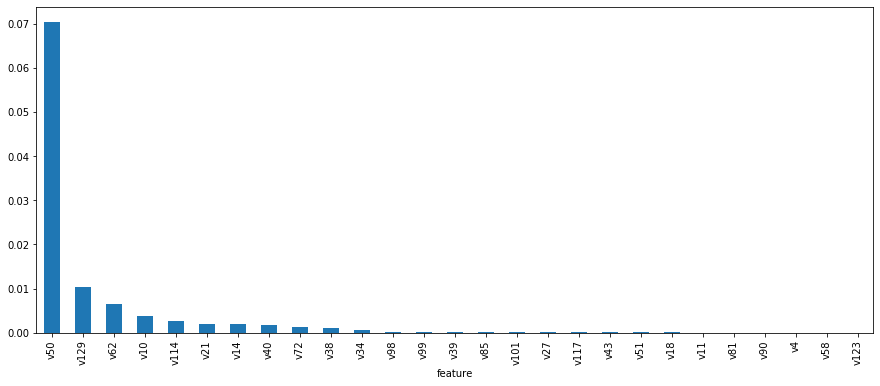

In [23]:
# and now let's plot the distribution of importances
# for those features that are actually important

# capture the important features in a series for visualisation
temp = pd.Series(feature_importance[feature_importance.auc_drop>0]['auc_drop'])
temp.index = pd.Series(feature_importance[feature_importance.auc_drop>0]['feature'])

pd.Series(temp).plot.bar(figsize=(15,6))

In [24]:
# Now let's build a random forests only with the 26 selected features

# capture the 26 selected features
selected_features = feature_importance[feature_importance.auc_drop>0]['feature']

# train a new random forests using only the selected features
rf = RandomForestClassifier(
    n_estimators=50, max_depth=2, random_state=2909, n_jobs=4)

rf.fit(X_train[selected_features].fillna(0), y_train)

# print roc-auc in train and testing sets
print('train auc score: ',
      roc_auc_score(y_train, (rf.predict_proba(X_train[selected_features].fillna(0)))[:, 1]))
print('test auc score: ',
      roc_auc_score(y_test, (rf.predict_proba(X_test[selected_features].fillna(0)))[:, 1]))

train auc score:  0.7013500870415712
test auc score:  0.6895027652510979


As you can see, the random forests with the selected features show a similar performance to the random forests built using all of the features. And yet, provides a simpler, faster and more reliable model, for implementation in a live scenario.

### Regression

In [25]:
# load dataset
data = pd.read_csv('houseprice_train.csv', nrows=50000)
data.shape

(1460, 81)

In [26]:
# In practice, feature selection should be done after data pre-processing,
# so ideally, all the categorical variables are encoded into numbers,
# and then you can assess how deterministic they are of the target

# here for simplicity I will use only numerical variables
# select numerical columns:

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

(1460, 38)

In [27]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['Id', 'SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((1022, 36), (438, 36))

In [28]:
# The first step to determine feature importance by feature shuffling
# is to build the machine learning model for which we want to 
# select features

# In this case, I will build Random Forests, but remember that 
# you can use this procedure for any other machine learning algorithm

# I build few and shallow trees to avoid overfitting
rf = RandomForestRegressor(
    n_estimators=100, max_depth=3, random_state=2909, n_jobs=4)

rf.fit(X_train.fillna(0), y_train)

# print roc-auc in train and testing sets
print('train rmse: ',
      np.sqrt(mean_squared_error(y_train, (rf.predict(X_train.fillna(0))))))
print('test rmse: ',
      np.sqrt(mean_squared_error(y_test, (rf.predict(X_test.fillna(0))))))

train rmse:  34125.46855017603
test rmse:  39164.18326517837


In [0]:
# in this cell, I will shuffle one by one, each feature of the dataset
# and then use the dataset with the shuffled variable to make predictions
# using the random forests I trained in the previous cell

# overall train rmse: using all the features
train_rmse = np.sqrt(
    mean_squared_error(y_train, (rf.predict(X_train.fillna(0)))))

# dictionary to capture the features, and the drop in rmse that they
# cause when shuffled
feature_dict = {}

# selection  logic
for feature in X_train.columns:
    X_train_c = X_train.copy()

    # shuffle individual feature
    X_train_c[feature] = X_train_c[feature].sample(frac=1).reset_index(
        drop=True)

    # make prediction with shuffled feature and calculate roc-auc
    shuff_rmse = np.sqrt(
        mean_squared_error(y_train, (rf.predict(X_train_c.fillna(0)))))

    # store the drop in roc-auc
    feature_dict[feature] = (train_rmse - shuff_rmse)

In [30]:
# Now I will transform the dictionary into a pandas dataframe
# for easy manipulation

feature_importance = pd.Series(feature_dict).reset_index()
feature_importance.columns = ['feature', 'rmse_drop']
feature_importance.head()

,feature,rmse_drop
0,MSSubClass,0.000000
1,LotFrontage,-46.698306
2,LotArea,-400.163796
3,OverallQual,-41518.029574
4,OverallCond,-6.967475


In [0]:
# Now I will sort the dataframe according to the drop in performance
# caused by feature shuffling

feature_importance.sort_values(by=['rmse_drop'], ascending=False, inplace=True)

In [33]:
# visualise the most predictive features

feature_importance.head(10)

,feature,rmse_drop
17,BsmtHalfBath,40.323204
34,MoSold,36.182700
35,YrSold,16.380107
21,KitchenAbvGr,0.000000
9,BsmtFinSF2,0.000000
19,HalfBath,0.000000
0,MSSubClass,0.000000
30,3SsnPorch,0.000000
32,PoolArea,0.000000
33,MiscVal,0.000000


There seem to be only 2 predictive features in this dataset!!

That is all for this lecture, I hope you enjoyed it and see you in the next one!